# BNC-RNC期权定价套利策略回测

## 策略逻辑
- **周五收盘(15:00)**: 计算BNC/RNC定价，生成因子信号
- **周一开盘(09:30)**: 根据信号执行交易
- **强信号**: 单边做多/做空A资产（强信号层）
- **弱信号**: 小规模单边交易（弱信号层）
- **中等信号**: 对冲交易，周内每日动态调整（中间层）
- **交易费用**: 万分之5

## 1. 配置参数（含风险控制）

In [1]:
# ========================================
# 回测参数配置
# ========================================

# Tushare Token（请填入您的token）
TUSHARE_TOKEN = 'e8b32a062b07c1c14db1df8a0a9620a96dbbf77ca073f44fcdfa7a87'  # 请替换为您的实际token

# 初始资金
INITIAL_CAPITAL = 1_000_000  # 100万

# 回测时间范围
BACKTEST_START = '2022-06-01'
BACKTEST_END = '2025-10-31'

# 交易费用
COMMISSION_RATE = 0.0005  # 万分之5

# 资金分配策略
ALLOCATION_TYPE = 'moderate'

# 相关系数计算窗口
RHO_WINDOW = 60

# 因子假设检验参数
MIN_FACTOR_SAMPLES = 5

# ========================================
# 风险控制参数（新增）
# ========================================

# 回撤止损参数
STOP_LOSS_THRESHOLD = -0.05 # -5% 止损线（可自定义）
ENABLE_STOP_LOSS = True      # 是否启用止损机制

# 止盈信号
TAKE_PROFIT_THRESHOLD = 0.10  # 10% 止盈线（可自定义）
ENABLE_TAKE_PROFIT = True     # 是否启用止盈机制

# 【新增】融券成本参数
SHORT_INTEREST_RATE = 0.08   # 融券年化利率，默认8%（可调整为0.09或0.10）
ENABLE_SHORT_COST = True     # 是否启用融券成本计算

# 数据路径
DATA_DIR = 'historical_data'

print(f"回测配置:")
print(f"  初始资金: {INITIAL_CAPITAL:,.0f}")
print(f"  回测区间: {BACKTEST_START} ~ {BACKTEST_END}")
print(f"  交易费用: {COMMISSION_RATE*10000:.1f}‱")
print(f"  资金分配: {ALLOCATION_TYPE}")
print(f"\n资产配置:")
print(f"  A资产: 510300 (沪深300ETF) - 标的资产")

print(f"  B资产: 159915 (创业板ETF) - 对冲资产")
print(f"  - 对冲逻辑: 利用大盘成长股风格差异降低风险")

print(f"\n风险控制:")
print(f"  - 中等信号: 510300+159915对冲组合 (大盘+成长股)")

print(f"  止损线: {STOP_LOSS_THRESHOLD*100:.1f}% {'(已启用)' if ENABLE_STOP_LOSS else '(已禁用)'}")
print(f"  - 强信号/弱信号: 单边交易510300")
print(f"\n⭐ 策略说明:")

回测配置:
  初始资金: 1,000,000
  回测区间: 2022-06-01 ~ 2025-10-31
  交易费用: 5.0‱
  资金分配: moderate

资产配置:
  A资产: 510300 (沪深300ETF) - 标的资产
  B资产: 159915 (创业板ETF) - 对冲资产
  - 对冲逻辑: 利用大盘成长股风格差异降低风险

风险控制:
  - 中等信号: 510300+159915对冲组合 (大盘+成长股)
  止损线: -5.0% (已启用)
  - 强信号/弱信号: 单边交易510300

⭐ 策略说明:


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')
import tushare as ts

# 导入项目模块
import option as op
import account as ac
import PositionManager as pm
import FactorGenerator as fg
import singnal as sg
import rho
import BNC as bnc
import RNC as rnc
import intraweek_rebalance as iwr  # 新增：日频调仓模块

print("模块导入成功")

模块导入成功


### 2.1 加载真实无风险利率数据

In [3]:
# ========================================
# 从Tushare获取真实无风险利率数据
# ========================================

# 设置Tushare token
ts.set_token(TUSHARE_TOKEN)
pro = ts.pro_api()

print("正在从Tushare获取无风险利率数据...")

# 获取Shibor数据（3个月期作为无风险利率的代理）
try:
    df_shibor = pro.shibor(
        start_date=BACKTEST_START.replace('-', ''),
        end_date=BACKTEST_END.replace('-', '')
    )
    
    # 转换日期格式
    df_shibor['date'] = pd.to_datetime(df_shibor['date'])
    
    # 使用3个月期Shibor作为无风险利率（3m列）
    df_rf = df_shibor[['date', '3m']].copy()
    df_rf.columns = ['date', 'rf_annual']
    
    # 将百分比转换为小数（Shibor数据通常是百分比形式）
    df_rf['rf_annual'] = df_rf['rf_annual'] / 100
    
    # 按日期排序
    df_rf = df_rf.sort_values('date').reset_index(drop=True)
    
    # 填充缺失日期（使用前向填充）
    date_range = pd.date_range(start=BACKTEST_START, end=BACKTEST_END, freq='D')
    df_rf_full = pd.DataFrame({'date': date_range})
    df_rf_full = df_rf_full.merge(df_rf, on='date', how='left')
    df_rf_full['rf_annual'] = df_rf_full['rf_annual'].fillna(method='ffill')
    df_rf_full['rf_annual'] = df_rf_full['rf_annual'].fillna(method='bfill')
    
    df_rf = df_rf_full
    
    print(f"✓ 成功获取Shibor数据（3个月期）")
    
except Exception as e:
    print(f"⚠️ 无法获取Shibor数据: {e}")
    print("使用备用方案：获取国债收益率数据...")
    
    try:
        # 备用方案：使用国债收益率
        df_yield = pro.yc_cb(
            start_date=BACKTEST_START.replace('-', ''),
            end_date=BACKTEST_END.replace('-', '')
        )
        
        df_yield['date'] = pd.to_datetime(df_yield['date'])
        
        # 使用1年期国债收益率
        df_rf = df_yield[['date', '1y']].copy()
        df_rf.columns = ['date', 'rf_annual']
        df_rf['rf_annual'] = df_rf['rf_annual'] / 100
        
        df_rf = df_rf.sort_values('date').reset_index(drop=True)
        
        # 填充缺失日期
        date_range = pd.date_range(start=BACKTEST_START, end=BACKTEST_END, freq='D')
        df_rf_full = pd.DataFrame({'date': date_range})
        df_rf_full = df_rf_full.merge(df_rf, on='date', how='left')
        df_rf_full['rf_annual'] = df_rf_full['rf_annual'].fillna(method='ffill')
        df_rf_full['rf_annual'] = df_rf_full['rf_annual'].fillna(method='bfill')
        
        df_rf = df_rf_full
        
        print(f"✓ 成功获取国债收益率数据（1年期）")
        
    except Exception as e2:
        print(f"⚠️ 无法获取国债收益率: {e2}")
        print("使用模拟数据作为最后备选...")
        
        # 最后备选：使用分段常数利率
        df_rf = pd.DataFrame({
            'date': pd.date_range(start=BACKTEST_START, end=BACKTEST_END, freq='D'),
        })
        
        def get_rf_rate(date):
            if date < pd.Timestamp('2020-07-01'):
                return 0.0250
            elif date < pd.Timestamp('2021-01-01'):
                return 0.0235
            elif date < pd.Timestamp('2021-07-01'):
                return 0.0220
            else:
                return 0.0210
        
        df_rf['rf_annual'] = df_rf['date'].apply(get_rf_rate)
        print("✓ 使用模拟分段利率数据")

# 创建快速查询函数
def get_risk_free_rate(current_date):
    """获取指定日期的无风险利率"""
    past_rates = df_rf[df_rf['date'] <= current_date]
    if len(past_rates) > 0:
        return past_rates['rf_annual'].iloc[-1]
    else:
        return df_rf['rf_annual'].iloc[0] if len(df_rf) > 0 else 0.025

print(f"\n无风险利率数据加载完成:")
print(f"  数据范围: {df_rf['date'].min().strftime('%Y-%m-%d')} ~ {df_rf['date'].max().strftime('%Y-%m-%d')}")
print(f"  利率范围: {df_rf['rf_annual'].min()*100:.2f}% ~ {df_rf['rf_annual'].max()*100:.2f}%")
print(f"  平均利率: {df_rf['rf_annual'].mean()*100:.2f}%")
print(f"  数据点数: {len(df_rf)}")

正在从Tushare获取无风险利率数据...
✓ 成功获取Shibor数据（3个月期）

无风险利率数据加载完成:
  数据范围: 2022-06-01 ~ 2025-10-31
  利率范围: 1.55% ~ 2.60%
  平均利率: 1.99%
  数据点数: 1249
✓ 成功获取Shibor数据（3个月期）

无风险利率数据加载完成:
  数据范围: 2022-06-01 ~ 2025-10-31
  利率范围: 1.55% ~ 2.60%
  平均利率: 1.99%
  数据点数: 1249


In [4]:
### 2.2 加载ETF周频和日频数据

## 2. 加载历史数据

### 2.1 加载真实无风险利率数据

### 2.2 加载ETF和期权数据

In [5]:
# ========================================
# 加载ETF周频数据
# ========================================

df_hs300_weekly = pd.read_csv(os.path.join(DATA_DIR, 'HS300_ETF_weekly.csv'))
df_cyb_weekly = pd.read_csv(os.path.join(DATA_DIR, 'CYB_ETF_weekly.csv'))  # 创业板ETF

df_hs300_weekly['trade_date'] = pd.to_datetime(df_hs300_weekly['trade_date'])
df_cyb_weekly['trade_date'] = pd.to_datetime(df_cyb_weekly['trade_date'])

# 筛选回测区间
df_hs300_weekly = df_hs300_weekly[
    (df_hs300_weekly['trade_date'] >= BACKTEST_START) & 
    (df_hs300_weekly['trade_date'] <= BACKTEST_END)
].reset_index(drop=True)

df_cyb_weekly = df_cyb_weekly[
    (df_cyb_weekly['trade_date'] >= BACKTEST_START) & 
    (df_cyb_weekly['trade_date'] <= BACKTEST_END)
].reset_index(drop=True)

print(f"\n周频ETF数据加载完成:")
print(f"  510300 (沪深300): {len(df_hs300_weekly)}周")
print(f"  159915 (创业板): {len(df_cyb_weekly)}周")

# ========================================
# 加载ETF日频数据 (用于计算相关系数和中间层日内调整)
# ========================================

df_hs300_daily = pd.read_csv(os.path.join(DATA_DIR, 'HS300_ETF_daily.csv'))
df_cyb_daily = pd.read_csv(os.path.join(DATA_DIR, 'CYB_ETF_daily.csv'))  # 创业板ETF

df_hs300_daily['trade_date'] = pd.to_datetime(df_hs300_daily['trade_date'])
df_cyb_daily['trade_date'] = pd.to_datetime(df_cyb_daily['trade_date'])

# 扩展日频数据范围（需要RHO_WINDOW天历史）
daily_start = pd.to_datetime(BACKTEST_START) - timedelta(days=RHO_WINDOW + 30)
df_hs300_daily = df_hs300_daily[
    (df_hs300_daily['trade_date'] >= daily_start) & 
    (df_hs300_daily['trade_date'] <= BACKTEST_END)
].reset_index(drop=True)

df_cyb_daily = df_cyb_daily[
    (df_cyb_daily['trade_date'] >= daily_start) & 
    (df_cyb_daily['trade_date'] <= BACKTEST_END)
].reset_index(drop=True)

print(f"\n日频ETF数据加载完成:")
print(f"  510300 (沪深300): {len(df_hs300_daily)}天")
print(f"  159915 (创业板): {len(df_cyb_daily)}天")



周频ETF数据加载完成:
  510300 (沪深300): 175周
  159915 (创业板): 175周

日频ETF数据加载完成:
  510300 (沪深300): 889天
  159915 (创业板): 889天


In [6]:
# ========================================
# 加载期权数据
# ========================================

df_opt_basic_300 = pd.read_csv(os.path.join(DATA_DIR, '300ETF_option_basic.csv'))
df_opt_basic_cyb = pd.read_csv(os.path.join(DATA_DIR, 'CYB_option_basic.csv'))
df_opt_daily_300 = pd.read_csv(os.path.join(DATA_DIR, '300ETF_option_daily.csv'))
df_opt_daily_cyb = pd.read_csv(os.path.join(DATA_DIR, 'CYB_option_daily.csv'))

# 转换日期格式
for df in [df_opt_basic_300, df_opt_basic_cyb]:
    df['list_date'] = pd.to_datetime(df['list_date'])
    df['delist_date'] = pd.to_datetime(df['delist_date'])

for df in [df_opt_daily_300, df_opt_daily_cyb]:
    df['trade_date'] = pd.to_datetime(df['trade_date'])

print(f"\n期权数据加载完成:")
print(f"  300ETF期权基础: {len(df_opt_basic_300)}个合约")
print(f"  创业板期权基础: {len(df_opt_basic_cyb)}个合约")
print(f"  300ETF期权日线: {len(df_opt_daily_300)}条记录")
print(f"  创业板期权日线: {len(df_opt_daily_cyb)}条记录")


期权数据加载完成:
  300ETF期权基础: 2546个合约
  创业板期权基础: 1506个合约
  300ETF期权日线: 170317条记录
  创业板期权日线: 98997条记录


## 3. 构建OptionChain辅助函数

In [7]:
def build_option_chain_for_date(trade_date, etf_symbol, spot_price, 
                                 df_opt_basic, df_opt_daily, risk_free_rate):
    """
    构建指定日期的OptionChain对象
    
    参数:
    trade_date: 交易日期 (周五)
    etf_symbol: '510300' or '159915'
    spot_price: ETF现货价格 (周五收盘价)
    df_opt_basic: 期权基础信息DataFrame
    df_opt_daily: 期权日线数据DataFrame
    risk_free_rate: 无风险利率
    
    返回:
    OptionChain对象
    """
    # 创建OptionChain
    opc = op.OptionChain(
        underlying=etf_symbol,
        spot_price=spot_price,
        risk_free_rate=risk_free_rate
    )
    
    # 筛选当日存续的期权
    active_opts = df_opt_basic[
        (df_opt_basic['list_date'] <= trade_date) &
        (df_opt_basic['delist_date'] >= trade_date)
    ]
    print(active_opts)
    
    if len(active_opts) == 0:
        return None
    
    # 获取当日期权价格数据
    daily_data = df_opt_daily[df_opt_daily['trade_date'] == trade_date]
    
    if len(daily_data) == 0:
        return None
    
    # 合并数据
    merged = active_opts.merge(daily_data, on='ts_code', how='inner')
    
    if len(merged) == 0:
        return None
    
    # 构建Option对象
    for _, row in merged.iterrows():
        # 流动性过滤：跳过成交量为0或NaN的期权
        if pd.isna(row['vol']) or row['vol'] == 0:
            continue
            
        option = op.Option(
            symbol=row['ts_code'],
            underlying_symbol=etf_symbol,
            strike_price=row['exercise_price'],
            spot_price=spot_price,
            expiry_date=row['delist_date'].strftime('%Y-%m-%d'),
            option_type='call' if row['call_put'] == 'C' else 'put',
            bid_price=row['close'] * 0.98,  # 简化处理
            ask_price=row['close'] * 1.02,
            last_price=row['close'],
            volume=int(row['vol']) if not pd.isna(row['vol']) else 0,
            open_interest=int(row['oi']) if not pd.isna(row['oi']) else 0,
            underlying_quantity=10000
        )
        
        opc.add_option(option)
    
    # 验证OptionChain是否有效
    if len(opc.option_chain) == 0:
        return None
    
    return opc

print("OptionChain构建函数定义完成")

OptionChain构建函数定义完成


## 4. 计算历史相关系数辅助函数

In [8]:
def get_historical_series(df_daily, current_date, window):
    """
    获取指定日期之前的历史收盘价序列
    
    参数:
    df_daily: 日频DataFrame
    current_date: 当前日期
    window: 历史窗口长度（交易日数）
    
    返回:
    收盘价序列 (list)
    """
    historical = df_daily[df_daily['trade_date'] < current_date].tail(window)
    return historical['close'].tolist()

print("历史序列获取函数定义完成")

历史序列获取函数定义完成


## 5. 初始化账户和管理器

## 4.5 IV计算诊断测试（新增）

In [9]:
# ========================================
# 初始化账户
# ========================================

account = ac.Account(initial_capital=INITIAL_CAPITAL)

# ========================================
# 初始化PositionManager
# ========================================

position_manager = pm.PositionManager(
    account=account,
    allow_short=True,  # 【修改】启用融券做空,允许在下跌行情中通过做空获利(需开通融资融券账户,当前未考虑融券成本)
    min_trade_unit=100,
    allocation_type=ALLOCATION_TYPE
)

# ========================================
# 初始化相关系数计算器
# ========================================

rho_calculator = rho.RhoCalculator()

# ========================================
# 初始化周内调仓器（新增）
# ========================================

intraweek_rebalancer = iwr.IntraweekRebalancer(
    position_manager=position_manager,
    commission_rate=COMMISSION_RATE,
    min_sharpe_increase=0.05  # 夏普比率至少提升0.05才调仓
)

print("\n账户和管理器初始化完成:")
print(f"  初始资金: {account.initial_capital:,.0f}")
print(f"  子账户分配: {position_manager.position_map}")
print(f"  周内调仓器: 已启用")

使用预设分配方案 'moderate': {'strong': 0.4, 'medium': 0.5, 'weak': 0.1}
子账户初始化完成，资金分配如下：
  strong: 40.00%
  medium: 50.00%
  weak: 10.00%
  ⚠️ 做空模式已启用，需确保标的可融券且考虑融券成本

账户和管理器初始化完成:
  初始资金: 1,000,000
  子账户分配: {'strong': 0.4, 'medium': 0.5, 'weak': 0.1}
  周内调仓器: 已启用


## 6. 回测主循环

In [10]:
# ========================================
# 回测记录
# ========================================

backtest_records = []
signal_history = []
stop_loss_triggered = False  # 止损标志
max_total_asset = INITIAL_CAPITAL  # 追踪历史最高资产

# 符号映射
SYMBOL_A = '510300'  # 沪深300ETF (A资产，标的)
SYMBOL_B = '159915'  # 创业板ETF (B资产，对冲)

# 动态阈值参数（新增）
BASE_THRESHOLD = 0.02  # 基础阈值：2%
THRESHOLD_LOOKBACK = 10  # 回溯窗口：10周

print("\n" + "="*80)
print("开始回测")
print("="*80)
print(f"动态阈值参数: 基础阈值={BASE_THRESHOLD*100:.1f}%, 回溯窗口={THRESHOLD_LOOKBACK}周")

# ========================================
# 遍历每周
# ========================================

for week_idx in range(MIN_FACTOR_SAMPLES, len(df_hs300_weekly)):
    
    # 当前周五
    friday_date = df_hs300_weekly.loc[week_idx, 'trade_date']
    
    # 获取周五收盘价（在循环开始就获取，用于止损检查）
    spot_A = df_hs300_weekly.loc[week_idx, 'close']
    spot_B = df_cyb_weekly.loc[week_idx, 'close']
    
    # ========================================
    # 止损检查（修正：清仓但继续交易）
    # ========================================
    if ENABLE_STOP_LOSS and len(backtest_records) > 0 and not stop_loss_triggered:
        # 计算当前资产（在任何交易前）
        market_prices = {SYMBOL_A: spot_A, SYMBOL_B: spot_B}
        account.update_total_asset(
            market_prices=market_prices,
            sub_accounts=list(position_manager.sub_accounts.values())
        )
        
        # 更新历史最高资产
        max_total_asset = max(max_total_asset, account.total_asset)
        
        # 计算回撤（相对于历史最高点）
        drawdown = (account.total_asset - max_total_asset) / max_total_asset
        
        if drawdown <= STOP_LOSS_THRESHOLD:
            print(f"\n{'='*80}")
            print(f"⚠️ 触发止损线！清空所有持仓")
            print(f"当前资产: {account.total_asset:,.0f}")
            print(f"历史最高: {max_total_asset:,.0f}")
            print(f"当前回撤: {drawdown*100:.2f}%")
            print(f"止损阈值: {STOP_LOSS_THRESHOLD*100:.1f}%")
            print(f"{'='*80}")
            
            # 清空所有持仓
            for signal_type, sub_acc in position_manager.sub_accounts.items():
                for symbol in list(sub_acc.holdings.keys()):
                    quantity = sub_acc.holdings.get(symbol, 0)
                    if quantity > 0:
                        price = spot_A if symbol == SYMBOL_A else spot_B
                        try:
                            sub_acc.sell_stock(
                                symbol=symbol,
                                price=price,
                                quantity=quantity,
                                trade_date=friday_date,
                                min_trade_unit=100
                            )
                            gain = quantity * price
                            commission = gain * COMMISSION_RATE
                            account.balance -= commission
                            print(f"  清仓 {quantity}股{symbol} @{price:.3f}")
                        except Exception as e:
                            print(f"  清仓失败: {e}")
            
            # 更新资产
            account.update_total_asset(
                market_prices=market_prices,
                sub_accounts=list(position_manager.sub_accounts.values()),
            )
            account.record_return()
            
            # 重置历史最高资产为当前资产（从这里重新开始计算）
            max_total_asset = account.total_asset
            
            # 记录止损状态
            backtest_records.append({
                'date': friday_date,
                'total_asset': account.total_asset,
                'balance': account.balance,
                'return': account.get_latest_return(),
                'signal_type': 'stop_loss',
                'action': 'liquidate',
                'rf_rate': get_risk_free_rate(friday_date)
            })
            
            stop_loss_triggered = True
            print(f"\n止损后总资产: {account.total_asset:,.0f}")
            print(f"继续运行策略...")
            print(f"{'='*80}\n")
            
            # 不要break，继续执行策略
    
    # ========================================
    # 止盈检查（新增）
    # ========================================
    if ENABLE_TAKE_PROFIT and len(backtest_records) > 0:
        # 如果还没更新过资产，先更新
        if not (ENABLE_STOP_LOSS and not stop_loss_triggered):
            market_prices = {SYMBOL_A: spot_A, SYMBOL_B: spot_B}
            account.update_total_asset(
                market_prices=market_prices,
                sub_accounts=list(position_manager.sub_accounts.values())
            )
        
        # 计算当前收益率（相对于初始资金）
        current_profit = (account.total_asset - INITIAL_CAPITAL) / INITIAL_CAPITAL
        
        if current_profit >= TAKE_PROFIT_THRESHOLD:
            print(f"\n{'='*80}")
            print(f"🎉 触发止盈线！清空所有持仓")
            print(f"当前资产: {account.total_asset:,.0f}")
            print(f"初始资金: {INITIAL_CAPITAL:,.0f}")
            print(f"当前收益: {current_profit*100:.2f}%")
            print(f"止盈阈值: {TAKE_PROFIT_THRESHOLD*100:.1f}%")
            print(f"{'='*80}")
            
            # 清空所有持仓
            market_prices = {SYMBOL_A: spot_A, SYMBOL_B: spot_B}
            for signal_type, sub_acc in position_manager.sub_accounts.items():
                for symbol in list(sub_acc.holdings.keys()):
                    quantity = sub_acc.holdings.get(symbol, 0)
                    if quantity != 0:  # 包括多头和空头
                        price = market_prices.get(symbol)
                        try:
                            if quantity > 0:
                                # 多头持仓：卖出
                                sub_acc.sell_stock(
                                    symbol=symbol,
                                    price=price,
                                    quantity=quantity,
                                    trade_date=friday_date,
                                    min_trade_unit=100
                                )
                                commission = quantity * price * COMMISSION_RATE
                            else:
                                # 空头持仓：买入平仓
                                sub_acc.buy_stock(
                                    symbol=symbol,
                                    price=price,
                                    quantity=abs(quantity),
                                    trade_date=friday_date,
                                    min_trade_unit=100
                                )
                                commission = abs(quantity) * price * COMMISSION_RATE
                            
                            account.balance -= commission
                            print(f"  清仓 {quantity}股{symbol} @{price:.3f}")
                        except Exception as e:
                            print(f"  清仓失败: {e}")
            
            # 更新资产
            account.update_total_asset(
                market_prices=market_prices,
                sub_accounts=list(position_manager.sub_accounts.values())
            )
            account.record_return()
            
            # 记录止盈状态
            backtest_records.append({
                'date': friday_date,
                'total_asset': account.total_asset,
                'balance': account.balance,
                'return': account.get_latest_return(),
                'signal_type': 'take_profit',
                'action': 'liquidate',
                'rf_rate': get_risk_free_rate(friday_date)
            })
            
            print(f"\n止盈后总资产: {account.total_asset:,.0f}")
            print(f"继续运行策略...")
            print(f"{'='*80}\n")
            
            continue  # 本周跳过交易，下周重新开始
    
    # 获取当前无风险利率（新增：使用真实利率）
    current_rf = get_risk_free_rate(friday_date)
    
    # 下周一开盘价（用于交易执行）
    if week_idx + 1 < len(df_hs300_weekly):
        monday_open_A = df_hs300_weekly.loc[week_idx + 1, 'open']
        monday_open_B = df_cyb_weekly.loc[week_idx + 1, 'open']
    else:
        monday_open_A = spot_A
        monday_open_B = spot_B
    
    print(f"\n[周 {week_idx+1}/{len(df_hs300_weekly)}] {friday_date.strftime('%Y-%m-%d')} (周五)")
    print(f"  510300收盘: {spot_A:.3f}, 159915收盘: {spot_B:.3f}")
    print(f"  当前无风险利率: {current_rf*100:.2f}%")
    if len(backtest_records) > 0:
        current_drawdown = (account.total_asset - max_total_asset) / max_total_asset
        print(f"  当前回撤: {current_drawdown*100:.2f}%")
    
    # ========================================
    # 周五收盘：计算因子和信号
    # ========================================
    
    try:
        # 构建OptionChain（使用真实利率）
        opc_A = build_option_chain_for_date(
            friday_date, SYMBOL_A, spot_A,
            df_opt_basic_300, df_opt_daily_300, current_rf
        )
        
        opc_B = build_option_chain_for_date(
            friday_date, SYMBOL_B, spot_B,
            df_opt_basic_cyb, df_opt_daily_cyb, current_rf
        )
        print(opc_A, opc_B)
        
        if opc_A is None or opc_B is None:
            print("  ⚠️  期权数据不足，跳过本周")
            
            # 即使跳过本周，也要更新资产和记录（修正：确保止损检查能继续）
            market_prices = {SYMBOL_A: spot_A, SYMBOL_B: spot_B}
            account.update_total_asset(
                market_prices=market_prices,
                sub_accounts=list(position_manager.sub_accounts.values())
            )
            account.record_return()
            
            backtest_records.append({
                'date': friday_date,
                'total_asset': account.total_asset,
                'balance': account.balance,
                'return': account.get_latest_return(),
                'signal_type': 'none',
                'action': 'skip_no_data',
                'rf_rate': current_rf
            })
            
            continue
        
        # 获取历史价格序列（用于计算rho）
        series_A = get_historical_series(df_hs300_daily, friday_date, RHO_WINDOW)
        series_B = get_historical_series(df_cyb_daily, friday_date, RHO_WINDOW)  # 使用创业板
        
        if len(series_A) < RHO_WINDOW or len(series_B) < RHO_WINDOW:
            print("  ⚠️  历史数据不足，跳过本周")
            
            # 即使跳过本周，也要更新资产和记录（修正）
            market_prices = {SYMBOL_A: spot_A, SYMBOL_B: spot_B}
            account.update_total_asset(
                market_prices=market_prices,
                sub_accounts=list(position_manager.sub_accounts.values())
            )
            account.record_return()
            
            backtest_records.append({
                'date': friday_date,
                'total_asset': account.total_asset,
                'balance': account.balance,
                'return': account.get_latest_return(),
                'signal_type': 'none',
                'action': 'skip_no_history',
                'rf_rate': current_rf
            })
            
            continue
        
        # 初始化FactorGenerator（使用真实利率）
        factor_gen = fg.FactorGenerator(
            opca=opc_A,
            opcb=opc_B,
            risk_free_rate=current_rf,
            current_date=friday_date,
            rho_calculator=rho_calculator
        )
        
        # 计算因子
        factor1, factor2, factor3 = factor_gen.compute_factors(series_A, series_B)
        
        # 计算动态阈值（显示）
        threshold1 = factor_gen.calculate_dynamic_threshold(factor_gen.factor1_history, BASE_THRESHOLD, THRESHOLD_LOOKBACK)
        threshold2 = factor_gen.calculate_dynamic_threshold(factor_gen.factor2_history, BASE_THRESHOLD, THRESHOLD_LOOKBACK)
        threshold3 = factor_gen.calculate_dynamic_threshold(factor_gen.factor3_history, BASE_THRESHOLD, THRESHOLD_LOOKBACK)
        
        print(f"  因子: F1={factor1:.4f}, F2={factor2:.4f}, F3={factor3:.4f}")
        print(f"  动态阈值: T1={threshold1:.4f}, T2={threshold2:.4f}, T3={threshold3:.4f}")
        
        # 初始化信号生成器
        signal_gen = sg.Singnal_Generator(
            fgenerator=factor_gen,
            threshold=1e-2  # 这个参数已废弃，保留仅为兼容性
        )
        
        # 生成信号（使用动态阈值参数）
        signal_dict = signal_gen.generate_signal(series_A, series_B, base_threshold=BASE_THRESHOLD, lookback=THRESHOLD_LOOKBACK)
        
        signal_type = signal_dict['signal_type']
        action = signal_dict['action']
        
        print(f"  信号: {signal_type.upper()} - {action}")
        
        signal_history.append({
            'date': friday_date,
            'signal_type': signal_type,
            'action': action,
            'factor1': factor1,
            'factor2': factor2,
            'factor3': factor3,
            'threshold1': threshold1,
            'threshold2': threshold2,
            'threshold3': threshold3,
            'rf_rate': current_rf
        })
        
        # ========================================
        # 周一开盘：执行交易
        # ========================================
        
        position_manager.set_current_date(friday_date)
        
        if signal_type in ['strong', 'weak']:
            if action in ['buy_A', 'sell_A']:
                if action == 'buy_A':
                    quantity = position_manager.calc_buy_size(
                        signal_dict, monday_open_A, single_trade_pct=0.25, symbol=SYMBOL_A
                    )
                    
                    if quantity > 0:
                        cost = quantity * monday_open_A
                        commission = cost * COMMISSION_RATE
                        sub_acc = position_manager.sub_accounts[signal_type]
                        try:
                            sub_acc.buy_stock(
                                symbol=SYMBOL_A,
                                price=monday_open_A,
                                quantity=quantity,
                                trade_date=friday_date,
                                min_trade_unit=100
                            )
                            account.balance -= commission
                            print(f"  ✓ 买入{quantity}股{SYMBOL_A} @{monday_open_A:.3f} (手续费{commission:.2f})")
                        except Exception as e:
                            print(f"  ✗ 买入失败: {e}")
                
                elif action == 'sell_A':
                    quantity = position_manager.calc_sell_size(
                        signal_dict, monday_open_A, symbol=SYMBOL_A
                    )
                    
                    if quantity > 0:
                        gain = quantity * monday_open_A
                        commission = gain * COMMISSION_RATE
                        sub_acc = position_manager.sub_accounts[signal_type]
                        try:
                            sub_acc.sell_stock(
                                symbol=SYMBOL_A,
                                price=monday_open_A,
                                quantity=quantity,
                                trade_date=friday_date,
                                min_trade_unit=100
                            )
                            account.balance -= commission
                            print(f"  ✓ 卖出{quantity}股{SYMBOL_A} @{monday_open_A:.3f} (手续费{commission:.2f})")
                        except Exception as e:
                            print(f"  ✗ 卖出失败: {e}")
        
        elif signal_type == 'medium':
            returns_A = pd.Series(series_A).pct_change().dropna().tolist()
            returns_B = pd.Series(series_B).pct_change().dropna().tolist()
            
            if len(returns_A) > 10 and len(returns_B) > 10:
                result = position_manager.calc_hedge_quantity(
                    symbolB=SYMBOL_B,
                    priceB=monday_open_B,
                    symbolA=SYMBOL_A,
                    priceA=monday_open_A,
                    returnB=returns_B,
                    returnA=returns_A,
                    risk_free_rate=current_rf,  # 使用真实利率
                    signal_dict=signal_dict,
                    target_exposure=1.0,
                    min_sharpe_increase=0.05
                )
                
                if result is not None:
                    trade_qtyB, trade_qtyA = result
                    try:
                        position_manager.execute_hedge_trade(
                            symbolB=SYMBOL_B,
                            symbolA=SYMBOL_A,
                            priceB=monday_open_B,
                            priceA=monday_open_A,
                            trade_quantityB=trade_qtyB,
                            trade_quantityA=trade_qtyA
                        )
                        
                        commission_B = abs(trade_qtyB * monday_open_B) * COMMISSION_RATE
                        commission_A = abs(trade_qtyA * monday_open_A) * COMMISSION_RATE
                        account.balance -= (commission_B + commission_A)
                        
                        print(f"  ✓ 对冲交易: B={trade_qtyB}, A={trade_qtyA} (手续费{commission_B+commission_A:.2f})")
                    except Exception as e:
                        print(f"  ✗ 对冲交易失败: {e}")
        
        # ========================================
        # 周内日频调仓（新增）
        # 仅对中等信号层进行周二~周五的调仓
        # ========================================
        
        if signal_type == 'medium' and week_idx + 1 < len(df_hs300_weekly):
            # 获取下周一到下周五的日期范围
            next_week_start = df_hs300_weekly.loc[week_idx + 1, 'trade_date']
            next_week_end = df_hs300_weekly.loc[week_idx, 'trade_date']  # 本周五
            
            # 获取本周的交易日（周一~周五）
            week_trading_dates = intraweek_rebalancer.get_week_trading_dates(
                df_hs300_daily, next_week_start, next_week_end
            )
            
            # 遍历周二~周五（跳过周一，因为已在主循环处理）
            for daily_date in week_trading_dates[1:]:  # [1:]跳过周一
                # 获取当日价格
                daily_priceA = df_hs300_daily[df_hs300_daily['trade_date'] == daily_date]['close'].values
                daily_priceB = df_cyb_daily[df_cyb_daily['trade_date'] == daily_date]['close'].values  # 使用创业板
                
                if len(daily_priceA) == 0 or len(daily_priceB) == 0:
                    continue
                
                daily_priceA = daily_priceA[0]
                daily_priceB = daily_priceB[0]
                
                # 执行日频调仓
                rebalance_result = intraweek_rebalancer.execute_intraweek_rebalance(
                    current_date=daily_date,
                    symbolA=SYMBOL_A,
                    symbolB=SYMBOL_B,
                    priceA=daily_priceA,
                    priceB=daily_priceB,
                    df_daily_A=df_hs300_daily,
                    df_daily_B=df_cyb_daily,  # 使用创业板
                    risk_free_rate=current_rf,
                    lookback_days=60
                )
                
                # 扣除手续费
                if rebalance_result is not None and rebalance_result['commission'] > 0:
                    account.balance -= rebalance_result['commission']
        
        # ========================================
        # 更新总资产
        # ========================================
        
        market_prices = {
            SYMBOL_A: spot_A,
            SYMBOL_B: spot_B
        }
        
        account.update_total_asset(
            market_prices=market_prices,
            sub_accounts=list(position_manager.sub_accounts.values())
        )
        
        # 【新增】计算并扣除融券成本
        if ENABLE_SHORT_COST and position_manager.allow_short:
            # 遍历所有子账户,统计空头持仓
            total_short_value = 0
            for sub_acc in position_manager.sub_accounts.values():
                for symbol, quantity in sub_acc.holdings.items():
                    if quantity < 0:  # 负持仓表示做空
                        price = market_prices.get(symbol, 0)
                        short_value = abs(quantity) * price
                        total_short_value += short_value
            
            # 计算周度融券成本 (年化利率 / 52周)
            if total_short_value > 0:
                weekly_short_cost = total_short_value * SHORT_INTEREST_RATE / 52
                account.balance -= weekly_short_cost
                # 重新更新总资产(扣除成本后)
                account.update_total_asset(
                    market_prices=market_prices,
                    sub_accounts=list(position_manager.sub_accounts.values())
                )
                print(f"  融券成本: {weekly_short_cost:.2f} (空头市值: {total_short_value:,.0f})")
        
        account.record_return()
        
        # 更新历史最高资产
        max_total_asset = max(max_total_asset, account.total_asset)
        
        # 记录回测数据
        backtest_records.append({
            'date': friday_date,
            'total_asset': account.total_asset,
            'balance': account.balance,
            'return': account.get_latest_return(),
            'signal_type': signal_type,
            'action': action,
            'rf_rate': current_rf
        })
        
        print(f"  总资产: {account.total_asset:,.0f}, 收益率: {account.get_latest_return()*100:.2f}%")
    
    except Exception as e:
        print(f"  ✗ 错误: {e}")
        import traceback
        traceback.print_exc()
        
        # 即使出错，也要更新资产和记录（修正）
        market_prices = {SYMBOL_A: spot_A, SYMBOL_B: spot_B}
        account.update_total_asset(
            market_prices=market_prices,
            sub_accounts=list(position_manager.sub_accounts.values())
        )
        account.record_return()
        
        backtest_records.append({
            'date': friday_date,
            'total_asset': account.total_asset,
            'balance': account.balance,
            'return': account.get_latest_return(),
            'signal_type': 'error',
            'action': 'skip_error',
            'rf_rate': current_rf
        })
        
        continue

print("\n" + "="*80)
# 检查止盈触发次数
take_profit_count = len([r for r in backtest_records if r.get('signal_type') == 'take_profit'])
if stop_loss_triggered:
    print("回测完成：曾触发止损（已清仓后继续交易）")
else:
    print("回测完成：未触发止损")
if take_profit_count > 0:
    print(f"回测完成：触发止盈 {take_profit_count} 次")
print("="*80)


开始回测
动态阈值参数: 基础阈值=2.0%, 回溯窗口=10周

[周 6/175] 2022-07-08 (周五)
  510300收盘: 4.464, 159915收盘: 2.731
  当前无风险利率: 1.99%
          ts_code exchange                      name  list_date delist_date  \
1328  10004267.SH      SSE  华泰柏瑞沪深300ETF期权2212认沽3.80 2022-04-28  2022-12-28   
1329  10004336.SH      SSE  华泰柏瑞沪深300ETF期权2212认沽4.70 2022-06-16  2022-12-28   
1330  10004272.SH      SSE  华泰柏瑞沪深300ETF期权2212认沽4.30 2022-04-28  2022-12-28   
1331  10004324.SH      SSE  华泰柏瑞沪深300ETF期权2212认沽4.60 2022-06-07  2022-12-28   
1332  10004270.SH      SSE  华泰柏瑞沪深300ETF期权2212认沽4.10 2022-04-28  2022-12-28   
...           ...      ...                       ...        ...         ...   
1499  10004321.SH      SSE  华泰柏瑞沪深300ETF期权2207认购4.60 2022-06-07  2022-07-27   
1500  10004309.SH      SSE  华泰柏瑞沪深300ETF期权2207认沽3.70 2022-05-26  2022-07-27   
1501  10004304.SH      SSE  华泰柏瑞沪深300ETF期权2207认购4.10 2022-05-26  2022-07-27   
1502  10004313.SH      SSE  华泰柏瑞沪深300ETF期权2207认沽4.10 2022-05-26  2022-07-27   
1503  10004380.SH 

## 7. 回测结果分析

In [11]:
# ========================================
# 转换为DataFrame
# ========================================

df_backtest = pd.DataFrame(backtest_records)
df_signals = pd.DataFrame(signal_history)

if len(df_backtest) == 0:
    print("回测无有效数据")
else:
    print(f"\n回测统计 ({len(df_backtest)}周):")
    print("="*80)
    
    # 止损/止盈状态显示
    take_profit_records = df_backtest[df_backtest['signal_type'] == 'take_profit']
    
    if stop_loss_triggered:
        print("\n⚠️ 止损状态: 已触发")
        stop_loss_records = df_backtest[df_backtest['signal_type'] == 'stop_loss']
        if len(stop_loss_records) > 0:
            print(f"止损日期: {stop_loss_records.iloc[0]['date'].strftime('%Y-%m-%d')}")
        print(f"止损阈值: {STOP_LOSS_THRESHOLD*100:.1f}%")
    else:
        print("\n✓ 止损状态: 未触发")
    
    if len(take_profit_records) > 0:
        print(f"\n🎉 止盈状态: 触发 {len(take_profit_records)} 次")
        for idx, record in take_profit_records.iterrows():
            print(f"  - {record['date'].strftime('%Y-%m-%d')}: 收益率 {record['return']*100:.2f}%")
        print(f"止盈阈值: {TAKE_PROFIT_THRESHOLD*100:.1f}%")
    else:
        print(f"\n✓ 止盈状态: 未触发 (阈值: {TAKE_PROFIT_THRESHOLD*100:.1f}%)")
    
    print("\n" + "="*80)
    
    # 最终收益
    final_return = df_backtest['return'].iloc[-1]
    print(f"\n总收益率: {final_return*100:.2f}%")
    print(f"初始资金: {INITIAL_CAPITAL:,.0f}")
    print(f"最终资金: {df_backtest['total_asset'].iloc[-1]:,.0f}")
    
    # 计算年化收益
    total_weeks = len(df_backtest)
    total_years = total_weeks / 52
    annualized_return = (1 + final_return) ** (1 / total_years) - 1
    print(f"年化收益率: {annualized_return*100:.2f}%")
    
    # 最大回撤
    cummax = df_backtest['total_asset'].cummax()
    drawdown = (df_backtest['total_asset'] - cummax) / cummax
    max_drawdown = drawdown.min()
    print(f"最大回撤: {max_drawdown*100:.2f}%")
    
    # 夏普比率（使用平均无风险利率）
    avg_rf_rate = df_backtest['rf_rate'].mean()
    weekly_returns = df_backtest['return'].diff().dropna()
    sharpe = (weekly_returns.mean() - avg_rf_rate/52) / weekly_returns.std() * np.sqrt(52)
    print(f"夏普比率: {sharpe:.2f}")
    print(f"平均无风险利率: {avg_rf_rate*100:.2f}%")
    
    # 信号统计
    print(f"\n信号分布:")
    print(df_signals['signal_type'].value_counts())
    
    print(f"\n动作分布:")
    print(df_signals['action'].value_counts())


回测统计 (171周):

⚠️ 止损状态: 已触发
止损日期: 2023-05-05
止损阈值: -5.0%

🎉 止盈状态: 触发 121 次
  - 2023-06-21: 收益率 9.95%
  - 2023-07-07: 收益率 24.79%
  - 2023-07-14: 收益率 24.79%
  - 2023-07-21: 收益率 24.79%
  - 2023-07-28: 收益率 24.79%
  - 2023-08-04: 收益率 24.79%
  - 2023-08-11: 收益率 24.79%
  - 2023-08-18: 收益率 24.79%
  - 2023-08-25: 收益率 24.79%
  - 2023-09-01: 收益率 24.79%
  - 2023-09-08: 收益率 24.79%
  - 2023-09-15: 收益率 24.79%
  - 2023-09-22: 收益率 24.79%
  - 2023-09-28: 收益率 24.79%
  - 2023-10-13: 收益率 24.79%
  - 2023-10-20: 收益率 24.79%
  - 2023-10-27: 收益率 24.79%
  - 2023-11-03: 收益率 24.79%
  - 2023-11-10: 收益率 24.79%
  - 2023-11-17: 收益率 24.79%
  - 2023-11-24: 收益率 24.79%
  - 2023-12-01: 收益率 24.79%
  - 2023-12-08: 收益率 24.79%
  - 2023-12-15: 收益率 24.79%
  - 2023-12-22: 收益率 24.79%
  - 2023-12-29: 收益率 24.79%
  - 2024-01-05: 收益率 24.79%
  - 2024-01-12: 收益率 24.79%
  - 2024-01-19: 收益率 24.79%
  - 2024-01-26: 收益率 24.79%
  - 2024-02-02: 收益率 24.79%
  - 2024-02-08: 收益率 24.79%
  - 2024-02-23: 收益率 24.79%
  - 2024-03-01: 收益率 24.79%
  - 2024

## 8. 可视化

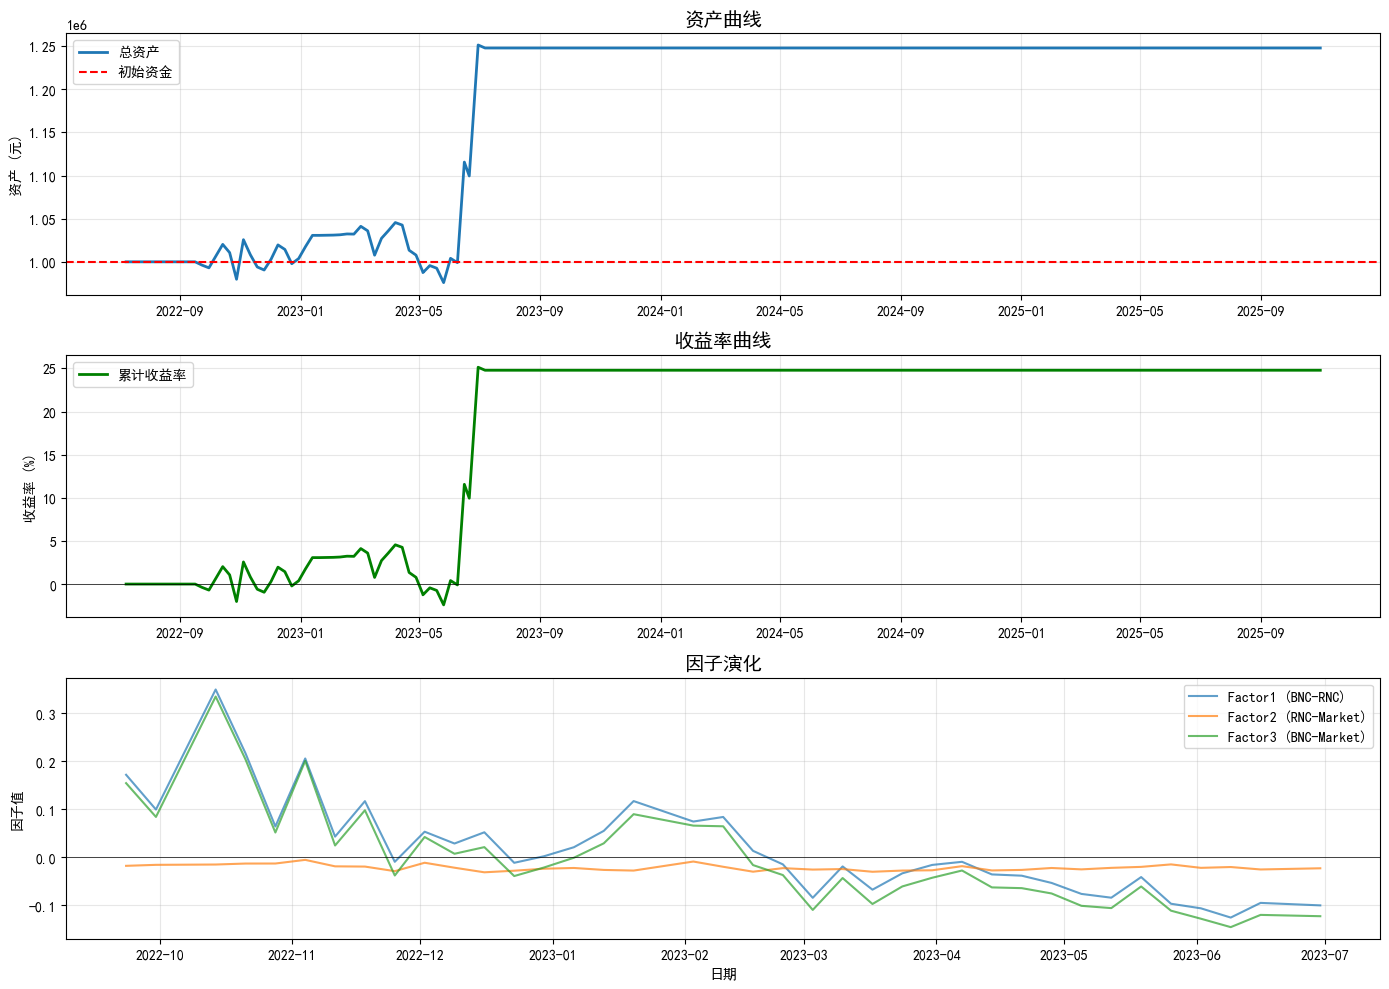

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体
plt.rcParams['axes.unicode_minus'] = False

if len(df_backtest) > 0:
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # 1. 资产曲线
    ax1 = axes[0]
    ax1.plot(df_backtest['date'], df_backtest['total_asset'], label='总资产', linewidth=2)
    ax1.axhline(INITIAL_CAPITAL, color='r', linestyle='--', label='初始资金')
    ax1.set_title('资产曲线', fontsize=14, fontweight='bold')
    ax1.set_ylabel('资产 (元)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # 2. 收益率曲线
    ax2 = axes[1]
    ax2.plot(df_backtest['date'], df_backtest['return']*100, label='累计收益率', color='green', linewidth=2)
    ax2.axhline(0, color='k', linestyle='-', linewidth=0.5)
    ax2.set_title('收益率曲线', fontsize=14, fontweight='bold')
    ax2.set_ylabel('收益率 (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # 3. 因子分布
    ax3 = axes[2]
    ax3.plot(df_signals['date'], df_signals['factor1'], label='Factor1 (BNC-RNC)', alpha=0.7)
    ax3.plot(df_signals['date'], df_signals['factor2'], label='Factor2 (RNC-Market)', alpha=0.7)
    ax3.plot(df_signals['date'], df_signals['factor3'], label='Factor3 (BNC-Market)', alpha=0.7)
    ax3.axhline(0, color='k', linestyle='-', linewidth=0.5)
    ax3.set_title('因子演化', fontsize=14, fontweight='bold')
    ax3.set_xlabel('日期')
    ax3.set_ylabel('因子值')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    plt.tight_layout()
    plt.show()
else:
    print("无数据可视化")

In [13]:
# ========================================
# 相对指数表现分析（新增）
# ========================================

if len(df_backtest) > 0 and len(df_hs300_weekly) > 0:
    print("\n" + "="*80)
    print("相对指数表现分析")
    print("="*80)
    
    # 获取回测期间的指数数据
    backtest_start_date = df_backtest['date'].iloc[0]
    backtest_end_date = df_backtest['date'].iloc[-1]
    
    # 筛选对应时间段的指数数据
    hs300_period = df_hs300_weekly[
        (df_hs300_weekly['trade_date'] >= backtest_start_date) & 
        (df_hs300_weekly['trade_date'] <= backtest_end_date)
    ].copy()
    
    cyb_period = df_cyb_weekly[
        (df_cyb_weekly['trade_date'] >= backtest_start_date) & 
        (df_cyb_weekly['trade_date'] <= backtest_end_date)
    ].copy()
    
    if len(hs300_period) > 0 and len(cyb_period) > 0:
        # 计算指数收益率
        hs300_start = hs300_period['close'].iloc[0]
        hs300_end = hs300_period['close'].iloc[-1]
        hs300_return = (hs300_end - hs300_start) / hs300_start
        
        cyb_start = cyb_period['close'].iloc[0]
        cyb_end = cyb_period['close'].iloc[-1]
        cyb_return = (cyb_end - cyb_start) / cyb_start
        
        # 策略收益率
        strategy_return = df_backtest['return'].iloc[-1]
        
        # 超额收益
        excess_return_hs300 = strategy_return - hs300_return
        excess_return_cyb = strategy_return - cyb_return
        
        print(f"\n期间收益率对比:")
        print(f"  策略收益率:     {strategy_return*100:>8.2f}%")
        print(f"  沪深300收益率:  {hs300_return*100:>8.2f}%")
        print(f"  创业板收益率:   {cyb_return*100:>8.2f}%")
        
        print(f"\n超额收益:")
        print(f"  相对沪深300:    {excess_return_hs300*100:>8.2f}% {'✓' if excess_return_hs300 > 0 else '✗'}")
        print(f"  相对创业板:     {excess_return_cyb*100:>8.2f}% {'✓' if excess_return_cyb > 0 else '✗'}")
        
        # 年化超额收益
        total_weeks = len(df_backtest)
        total_years = total_weeks / 52
        
        strategy_annual = (1 + strategy_return) ** (1 / total_years) - 1
        hs300_annual = (1 + hs300_return) ** (1 / total_years) - 1
        cyb_annual = (1 + cyb_return) ** (1 / total_years) - 1
        
        excess_annual_hs300 = strategy_annual - hs300_annual
        excess_annual_cyb = strategy_annual - cyb_annual
        
        print(f"\n年化收益率对比:")
        print(f"  策略年化:       {strategy_annual*100:>8.2f}%")
        print(f"  沪深300年化:    {hs300_annual*100:>8.2f}%")
        print(f"  创业板年化:     {cyb_annual*100:>8.2f}%")
        
        print(f"\n年化超额收益:")
        print(f"  相对沪深300:    {excess_annual_hs300*100:>8.2f}% {'✓' if excess_annual_hs300 > 0 else '✗'}")
        print(f"  相对创业板:     {excess_annual_cyb*100:>8.2f}% {'✓' if excess_annual_cyb > 0 else '✗'}")
        
        # 计算信息比率（相对沪深300）
        # 合并策略和指数的周度收益率
        df_compare = pd.DataFrame({
            'date': df_backtest['date'],
            'strategy_return': df_backtest['return']
        })
        
        df_compare = df_compare.merge(
            hs300_period[['trade_date', 'close']].rename(columns={'trade_date': 'date'}),
            on='date',
            how='left'
        )
        df_compare['hs300_return'] = (df_compare['close'] / hs300_start) - 1
        
        df_compare = df_compare.merge(
            cyb_period[['trade_date', 'close']].rename(columns={'trade_date': 'date', 'close': 'cyb_close'}),
            on='date',
            how='left'
        )
        df_compare['cyb_return'] = (df_compare['cyb_close'] / cyb_start) - 1
        
        # 计算超额收益序列
        df_compare['excess_hs300'] = df_compare['strategy_return'] - df_compare['hs300_return']
        df_compare['excess_cyb'] = df_compare['strategy_return'] - df_compare['cyb_return']
        
        # 信息比率 = 平均超额收益 / 超额收益标准差
        ir_hs300 = df_compare['excess_hs300'].mean() / df_compare['excess_hs300'].std() * np.sqrt(52)
        ir_cyb = df_compare['excess_cyb'].mean() / df_compare['excess_cyb'].std() * np.sqrt(52)
        
        print(f"\n信息比率 (Information Ratio):")
        print(f"  相对沪深300:    {ir_hs300:>8.3f}")
        print(f"  相对创业板:     {ir_cyb:>8.3f}")
        
        # 计算夏普比率（新增）
        # 获取平均无风险利率
        avg_rf = df_backtest['rf_rate'].mean()
        
        # 计算周度收益率序列
        df_compare['strategy_weekly_return'] = df_compare['strategy_return'].diff()
        df_compare['hs300_weekly_return'] = df_compare['hs300_return'].diff()
        df_compare['cyb_weekly_return'] = df_compare['cyb_return'].diff()
        
        # 去除第一行（NaN）
        weekly_data = df_compare.dropna()
        
        # 策略夏普比率（已在结果分析部分计算，这里重新计算以保持一致）
        strategy_sharpe = (weekly_data['strategy_weekly_return'].mean() - avg_rf/52) / weekly_data['strategy_weekly_return'].std() * np.sqrt(52)
        
        # 沪深300夏普比率
        hs300_sharpe = (weekly_data['hs300_weekly_return'].mean() - avg_rf/52) / weekly_data['hs300_weekly_return'].std() * np.sqrt(52)
        
        # 创业板夏普比率
        cyb_sharpe = (weekly_data['cyb_weekly_return'].mean() - avg_rf/52) / weekly_data['cyb_weekly_return'].std() * np.sqrt(52)
        
        print(f"\n夏普比率 (Sharpe Ratio):")
        print(f"  策略:           {strategy_sharpe:>8.3f}")
        print(f"  沪深300:        {hs300_sharpe:>8.3f}")
        print(f"  创业板:         {cyb_sharpe:>8.3f}")
        
        # 胜率统计
        win_rate_hs300 = (df_compare['excess_hs300'] > 0).sum() / len(df_compare) * 100
        win_rate_cyb = (df_compare['excess_cyb'] > 0).sum() / len(df_compare) * 100
        
        print(f"\n周度胜率 (策略收益率超过指数的周数占比):")
        print(f"  相对沪深300:    {win_rate_hs300:>8.2f}%")
        print(f"  相对创业板:     {win_rate_cyb:>8.2f}%")
        
        # 最大相对回撤
        df_compare['cummax_excess_hs300'] = df_compare['excess_hs300'].cummax()
        df_compare['drawdown_vs_hs300'] = df_compare['excess_hs300'] - df_compare['cummax_excess_hs300']
        max_relative_dd_hs300 = df_compare['drawdown_vs_hs300'].min()
        
        df_compare['cummax_excess_cyb'] = df_compare['excess_cyb'].cummax()
        df_compare['drawdown_vs_cyb'] = df_compare['excess_cyb'] - df_compare['cummax_excess_cyb']
        max_relative_dd_cyb = df_compare['drawdown_vs_cyb'].min()
        
        print(f"\n最大相对回撤:")
        print(f"  相对沪深300:    {max_relative_dd_hs300*100:>8.2f}%")
        print(f"  相对创业板:     {max_relative_dd_cyb*100:>8.2f}%")
        
        print("\n" + "="*80)
        
        # 保存对比数据到CSV
        df_compare_output = df_compare[[
            'date', 'strategy_return', 'hs300_return', 'cyb_return',
            'excess_hs300', 'excess_cyb'
        ]].copy()
        df_compare_output.columns = [
            '日期', '策略收益率', '沪深300收益率', '创业板收益率',
            '超额收益_沪深300', '超额收益_创业板'
        ]
        df_compare_output.to_csv('index_comparison.csv', index=False, encoding='utf-8-sig')
        print("\n相对指数表现已保存至: index_comparison.csv")
        
    else:
        print("⚠️ 指数数据不足，无法计算相对表现")
else:
    print("⚠️ 回测数据不足，无法计算相对表现")


相对指数表现分析

期间收益率对比:
  策略收益率:        24.79%
  沪深300收益率:      6.54%
  创业板收益率:      15.93%

超额收益:
  相对沪深300:       18.25% ✓
  相对创业板:         8.86% ✓

年化收益率对比:
  策略年化:           6.97%
  沪深300年化:        1.95%
  创业板年化:         4.60%

年化超额收益:
  相对沪深300:        5.02% ✓
  相对创业板:         2.37% ✓

信息比率 (Information Ratio):
  相对沪深300:      15.318
  相对创业板:       14.331

夏普比率 (Sharpe Ratio):
  策略:              0.470
  沪深300:           0.001
  创业板:            0.131

周度胜率 (策略收益率超过指数的周数占比):
  相对沪深300:       99.42%
  相对创业板:        99.42%

最大相对回撤:
  相对沪深300:      -35.44%
  相对创业板:       -62.58%


相对指数表现已保存至: index_comparison.csv


## 9. 导出结果

In [14]:
# 保存回测结果
if len(df_backtest) > 0:
    df_backtest.to_csv('backtest_results.csv', index=False, encoding='utf-8-sig')
    df_signals.to_csv('signal_history.csv', index=False, encoding='utf-8-sig')
    print("回测结果已保存:")
    print("  - backtest_results.csv")
    print("  - signal_history.csv")

回测结果已保存:
  - backtest_results.csv
  - signal_history.csv


In [15]:
# ========================================
# 手动诊断测试 - 选取几个日期强制计算
# ========================================

print("="*80)
print("手动诊断测试 - 逐步调试IV和因子计算")
print("="*80)

# 选取3个测试日期
test_indices = [MIN_FACTOR_SAMPLES + 5, MIN_FACTOR_SAMPLES + 10, MIN_FACTOR_SAMPLES + 15]

for test_idx in test_indices:
    if test_idx >= len(df_hs300_weekly):
        continue
        
    test_date = df_hs300_weekly.loc[test_idx, 'trade_date']
    test_spot_A = df_hs300_weekly.loc[test_idx, 'close']
    test_spot_B = df_cyb_weekly.loc[test_idx, 'close']
    test_rf = get_risk_free_rate(test_date)
    
    print(f"\n{'='*80}")
    print(f"测试日期 {test_idx - MIN_FACTOR_SAMPLES + 1}: {test_date.strftime('%Y-%m-%d')}")
    print(f"{'='*80}")
    print(f"沪深300价格: {test_spot_A:.3f}")
    print(f"创业板价格: {test_spot_B:.3f}")
    print(f"无风险利率: {test_rf*100:.2f}%")
    
    try:
        # 步骤1: 构建OptionChain
        print(f"\n[步骤1] 构建OptionChain...")
        opc_A = build_option_chain_for_date(
            test_date, '510300', test_spot_A,
            df_opt_basic_300, df_opt_daily_300, test_rf
        )
        
        opc_B = build_option_chain_for_date(
            test_date, '159915', test_spot_B,
            df_opt_basic_cyb, df_opt_daily_cyb, test_rf
        )
        
        if opc_A is None or opc_B is None:
            print("  ✗ OptionChain构建失败")
            continue
        
        # 统计期权数量
        count_A = sum(len(strikes_dict) for strikes_dict in opc_A.option_chain.values())
        count_B = sum(len(strikes_dict) for strikes_dict in opc_B.option_chain.values())
        print(f"  ✓ OptionChain A: {count_A}个期权")
        print(f"  ✓ OptionChain B: {count_B}个期权")
        
        # 步骤2: 测试IV计算
        print(f"\n[步骤2] 测试IV计算...")
        from ImpliedV import ImpliedVolatility
        
        # 测试A资产期权IV
        iv_calc_A = ImpliedVolatility(opc_A)
        iv_list_A = iv_calc_A.IV_series(test_date, test_rf)
        valid_iv_A = [iv for iv in iv_list_A if iv is not None]
        print(f"  A资产: 总计{len(iv_list_A)}个期权, 成功计算{len(valid_iv_A)}个IV")
        if len(valid_iv_A) > 0:
            print(f"    IV范围: {min(valid_iv_A):.4f} ~ {max(valid_iv_A):.4f}")
            print(f"    IV均值: {np.mean(valid_iv_A):.4f}")
        else:
            print(f"    ✗ 所有期权的IV计算都失败")
        
        # 测试B资产期权IV
        iv_calc_B = ImpliedVolatility(opc_B)
        iv_list_B = iv_calc_B.IV_series(test_date, test_rf)
        valid_iv_B = [iv for iv in iv_list_B if iv is not None]
        print(f"  B资产: 总计{len(iv_list_B)}个期权, 成功计算{len(valid_iv_B)}个IV")
        if len(valid_iv_B) > 0:
            print(f"    IV范围: {min(valid_iv_B):.4f} ~ {max(valid_iv_B):.4f}")
            print(f"    IV均值: {np.mean(valid_iv_B):.4f}")
        else:
            print(f"    ✗ 所有期权的IV计算都失败")
        
        # 步骤3: 测试RNC计算
        print(f"\n[步骤3] 测试RNC计算...")
        if len(valid_iv_A) == 0:
            print(f"  ✗ 跳过RNC计算 (没有有效的IV)")
        else:
            try:
                rnc_calc = rnc.RnPricing(opc_A, test_rf, test_date)
                
                # 先测试build_iv_curve
                print("  尝试构建IV曲线...")
                iv_curve = rnc_calc.build_iv_curve()
                print(f"  ✓ IV曲线构建成功")
                
                # 测试理论价格计算
                print("  尝试计算RNC理论价格...")
                rnc_price = rnc_calc.calculate_asset_theoretical_price()
                print(f"  ✓ RNC理论价格: {rnc_price:.4f}")
                
            except ValueError as ve:
                print(f"  ✗ RNC计算失败: {ve}")
            except Exception as e:
                print(f"  ✗ RNC计算出错: {type(e).__name__}: {e}")
        
        # 步骤4: 测试BNC计算
        print(f"\n[步骤4] 测试BNC计算...")
        if len(valid_iv_A) == 0 or len(valid_iv_B) == 0:
            print(f"  ✗ 跳过BNC计算 (A或B的IV计算失败)")
        else:
            try:
                series_A = get_historical_series(df_hs300_daily, test_date, RHO_WINDOW)
                series_B = get_historical_series(df_cyb_daily, test_date, RHO_WINDOW)
                
                if len(series_A) >= RHO_WINDOW and len(series_B) >= RHO_WINDOW:
                    relation = rho_calculator.compute_rho(series_A, series_B)
                    print(f"  相关系数: {relation:.4f}")
                    
                    bnc_calc = bnc.BassetPricingCalculator(opc_A, opc_B, test_rf)
                    bnc_price = bnc_calc.expected_price_A_in_B(test_date, relation)
                    print(f"  ✓ BNC理论价格: {bnc_price:.4f}")
                else:
                    print(f"  ✗ 历史数据不足")
                    
            except Exception as e:
                print(f"  ✗ BNC计算出错: {type(e).__name__}: {e}")
        
        # 步骤5: 测试完整因子计算
        print(f"\n[步骤5] 测试完整因子计算...")
        if len(valid_iv_A) == 0 or len(valid_iv_B) == 0:
            print(f"  ✗ 跳过因子计算 (A或B的IV计算失败)")
        else:
            try:
                series_A = get_historical_series(df_hs300_daily, test_date, RHO_WINDOW)
                series_B = get_historical_series(df_cyb_daily, test_date, RHO_WINDOW)
                
                if len(series_A) >= RHO_WINDOW and len(series_B) >= RHO_WINDOW:
                    factor_gen_test = fg.FactorGenerator(
                        opca=opc_A,
                        opcb=opc_B,
                        risk_free_rate=test_rf,
                        current_date=test_date,
                        rho_calculator=rho_calculator
                    )
                    
                    f1, f2, f3 = factor_gen_test.compute_factors(series_A, series_B)
                    print(f"  ✓ 因子计算成功!")
                    print(f"    Factor1 (BNC-RNC): {f1:.4f}")
                    print(f"    Factor2 (RNC-Market): {f2:.4f}")
                    print(f"    Factor3 (BNC-Market): {f3:.4f}")
                else:
                    print(f"  ✗ 历史数据不足")
                    
            except ValueError as ve:
                print(f"  ✗ 因子计算失败: {ve}")
            except Exception as e:
                print(f"  ✗ 因子计算出错: {type(e).__name__}: {e}")
            
    except Exception as e:
        print(f"\n✗ 整体测试失败: {type(e).__name__}: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "="*80)
print("诊断测试完成")
print("="*80)


手动诊断测试 - 逐步调试IV和因子计算

测试日期 6: 2022-08-12
沪深300价格: 4.255
创业板价格: 2.613
无风险利率: 1.62%

[步骤1] 构建OptionChain...
          ts_code exchange                       name  list_date delist_date  \
1183  10004423.SH      SSE   华泰柏瑞沪深300ETF期权2303认购3.84 2022-07-28  2023-03-22   
1184  10004439.SH      SSE  华泰柏瑞沪深300ETF期权2303认沽4.529 2022-07-28  2023-03-22   
1188  10004425.SH      SSE  华泰柏瑞沪深300ETF期权2303认购4.037 2022-07-28  2023-03-22   
1189  10004443.SH      SSE  华泰柏瑞沪深300ETF期权2303认购3.741 2022-08-01  2023-03-22   
1190  10004444.SH      SSE  华泰柏瑞沪深300ETF期权2303认沽3.741 2022-08-01  2023-03-22   
...           ...      ...                        ...        ...         ...   
1471  10004360.SH      SSE   华泰柏瑞沪深300ETF期权2208认购4.00 2022-06-23  2022-08-24   
1472  10004369.SH      SSE   华泰柏瑞沪深300ETF期权2208认沽4.00 2022-06-23  2022-08-24   
1473  10004453.SH      SSE   华泰柏瑞沪深300ETF期权2208认购3.70 2022-08-04  2022-08-24   
1474  10004454.SH      SSE   华泰柏瑞沪深300ETF期权2208认沽3.70 2022-08-04  2022-08-24   
1475  10004359

## 10. BNC修复验证测试

In [16]:
# 验证BNC修复：统计成功率
print("="*80)
print("BNC计算成功率统计")
print("="*80)

success_count = 0
fail_count = 0
test_sample_size = min(20, len(df_hs300_weekly) - MIN_FACTOR_SAMPLES)

for i in range(test_sample_size):
    test_idx = MIN_FACTOR_SAMPLES + i
    test_date = df_hs300_weekly.loc[test_idx, 'trade_date']
    test_spot_A = df_hs300_weekly.loc[test_idx, 'close']
    test_spot_B = df_cyb_weekly.loc[test_idx, 'close']
    test_rf = get_risk_free_rate(test_date)
    
    try:
        opc_A = build_option_chain_for_date(
            test_date, '510300', test_spot_A,
            df_opt_basic_300, df_opt_daily_300, test_rf
        )
        
        opc_B = build_option_chain_for_date(
            test_date, '159915', test_spot_B,
            df_opt_basic_cyb, df_opt_daily_cyb, test_rf
        )
        
        if opc_A is None or opc_B is None:
            fail_count += 1
            continue
        
        series_A = get_historical_series(df_hs300_daily, test_date, RHO_WINDOW)
        series_B = get_historical_series(df_cyb_daily, test_date, RHO_WINDOW)
        
        if len(series_A) < RHO_WINDOW or len(series_B) < RHO_WINDOW:
            fail_count += 1
            continue
        
        relation = rho_calculator.compute_rho(series_A, series_B)
        bnc_calc = bnc.BassetPricingCalculator(opc_A, opc_B, test_rf)
        bnc_price = bnc_calc.expected_price_A_in_B(test_date, relation)
        
        success_count += 1
        print(f"✓ 日期 {test_date.strftime('%Y-%m-%d')}: BNC={bnc_price:.4f}")
        
    except Exception as e:
        fail_count += 1
        print(f"✗ 日期 {test_date.strftime('%Y-%m-%d')}: {type(e).__name__}")

print(f"\n{'='*80}")
print(f"测试完成: 成功 {success_count}/{test_sample_size} ({success_count/test_sample_size*100:.1f}%)")
print(f"{'='*80}")


BNC计算成功率统计
          ts_code exchange                      name  list_date delist_date  \
1328  10004267.SH      SSE  华泰柏瑞沪深300ETF期权2212认沽3.80 2022-04-28  2022-12-28   
1329  10004336.SH      SSE  华泰柏瑞沪深300ETF期权2212认沽4.70 2022-06-16  2022-12-28   
1330  10004272.SH      SSE  华泰柏瑞沪深300ETF期权2212认沽4.30 2022-04-28  2022-12-28   
1331  10004324.SH      SSE  华泰柏瑞沪深300ETF期权2212认沽4.60 2022-06-07  2022-12-28   
1332  10004270.SH      SSE  华泰柏瑞沪深300ETF期权2212认沽4.10 2022-04-28  2022-12-28   
...           ...      ...                       ...        ...         ...   
1499  10004321.SH      SSE  华泰柏瑞沪深300ETF期权2207认购4.60 2022-06-07  2022-07-27   
1500  10004309.SH      SSE  华泰柏瑞沪深300ETF期权2207认沽3.70 2022-05-26  2022-07-27   
1501  10004304.SH      SSE  华泰柏瑞沪深300ETF期权2207认购4.10 2022-05-26  2022-07-27   
1502  10004313.SH      SSE  华泰柏瑞沪深300ETF期权2207认沽4.10 2022-05-26  2022-07-27   
1503  10004380.SH      SSE  华泰柏瑞沪深300ETF期权2207认沽4.80 2022-06-24  2022-07-27   

     exercise_type call_put  exercise_pr

## 11. 止盈功能说明

In [17]:
print("="*80)
print("止盈功能说明")
print("="*80)

print("\n📊 当前配置:")
print(f"  止盈阈值: {TAKE_PROFIT_THRESHOLD*100:.1f}%")
print(f"  止盈开关: {'✓ 已启用' if ENABLE_TAKE_PROFIT else '✗ 已禁用'}")
print(f"  初始资金: {INITIAL_CAPITAL:,.0f}")

print("\n🎯 触发条件:")
print(f"  当账户总资产达到 {INITIAL_CAPITAL * (1 + TAKE_PROFIT_THRESHOLD):,.0f} 元时")
print(f"  即收益率达到 {TAKE_PROFIT_THRESHOLD*100:.1f}%")

print("\n💡 执行逻辑:")
print("  1. 每周五收盘前检查当前收益率")
print("  2. 如果收益率 ≥ 止盈阈值，立即清空所有持仓（多头和空头）")
print("  3. 扣除清仓手续费（按成交金额万分之5）")
print("  4. 记录止盈事件，继续运行策略")
print("  5. 下周重新开始交易")

print("\n📋 手续费计算:")
print("  - 多头平仓: 卖出数量 × 价格 × 0.0005")
print("  - 空头平仓: 买入数量 × 价格 × 0.0005")
print("  - 对冲持仓: A资产手续费 + B资产手续费")

print("\n⚠️ 注意事项:")
print("  - 止盈不会终止回测，只是清仓后继续运行")
print("  - 可以多次触发止盈")
print("  - 止盈优先级高于新信号交易（触发止盈的那周不交易）")
print("  - 手续费按实际成交金额（交易规模）收取，非固定金额")

print("\n" + "="*80)


止盈功能说明

📊 当前配置:
  止盈阈值: 10.0%
  止盈开关: ✓ 已启用
  初始资金: 1,000,000

🎯 触发条件:
  当账户总资产达到 1,100,000 元时
  即收益率达到 10.0%

💡 执行逻辑:
  1. 每周五收盘前检查当前收益率
  2. 如果收益率 ≥ 止盈阈值，立即清空所有持仓（多头和空头）
  3. 扣除清仓手续费（按成交金额万分之5）
  4. 记录止盈事件，继续运行策略
  5. 下周重新开始交易

📋 手续费计算:
  - 多头平仓: 卖出数量 × 价格 × 0.0005
  - 空头平仓: 买入数量 × 价格 × 0.0005
  - 对冲持仓: A资产手续费 + B资产手续费

⚠️ 注意事项:
  - 止盈不会终止回测，只是清仓后继续运行
  - 可以多次触发止盈
  - 止盈优先级高于新信号交易（触发止盈的那周不交易）
  - 手续费按实际成交金额（交易规模）收取，非固定金额

